In [12]:
import numpy as np
import astropy.convolution as cnv
import matplotlib.pyplot as plt
import pandas as pd
import os
import spikeinterface.extractors as se

def get_ratemaps(spikes, x, y, n: int, binsize = 15, stddev = 5):
    """
    Calculate the rate map for given spikes and positions.

    Args:
        spikes (array): spike train for unit
        x (array): x positions of animal
        y (array): y positions of animal
        n (int): kernel size for convolution
        binsize (int, optional): binning size of x and y data. Defaults to 15.
        stddev (int, optional): gaussian standard deviation. Defaults to 5.

    Returns:
        rmap: 2D array of rate map
        x_edges: edges of x bins
        y_edges: edges of y bins
    """
    x_bins = np.arange(np.nanmin(x), np.nanmax(x) + binsize, binsize)
    y_bins = np.arange(np.nanmin(y), np.nanmax(y)+ binsize, binsize)

    pos_binned, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins])
    

    spikes_x = x[spikes]
    spikes_y = y[spikes]
    spikes_binned, _, _ = np.histogram2d(spikes_x, spikes_y, bins=[x_bins, y_bins])
    
    g = cnv.Box2DKernel(n)
    g = cnv.Gaussian2DKernel(stddev, x_size=n, y_size=n)
    g = np.array(g)
    smoothed_spikes =cnv.convolve(spikes_binned, g)
    smoothed_pos = cnv.convolve(pos_binned, g)
    rmap = smoothed_spikes/smoothed_pos
    return rmap, x_edges, y_edges, pos_binned, spikes_binned, smoothed_pos, smoothed_spikes


In [45]:
x = np.random.normal(loc=50, scale=15, size=100)
y = np.random.normal(loc=50, scale=15, size=100)
spikes = np.random.uniform(0,100,100)
spikes = [np.int32(el) for el in spikes]

C:\Users\eylon\AppData\Local\Temp\ipykernel_41116\220557875.py:17: RuntimeWarning: invalid value encountered in divide
  rmap = smoothed_spikes/smoothed_pos


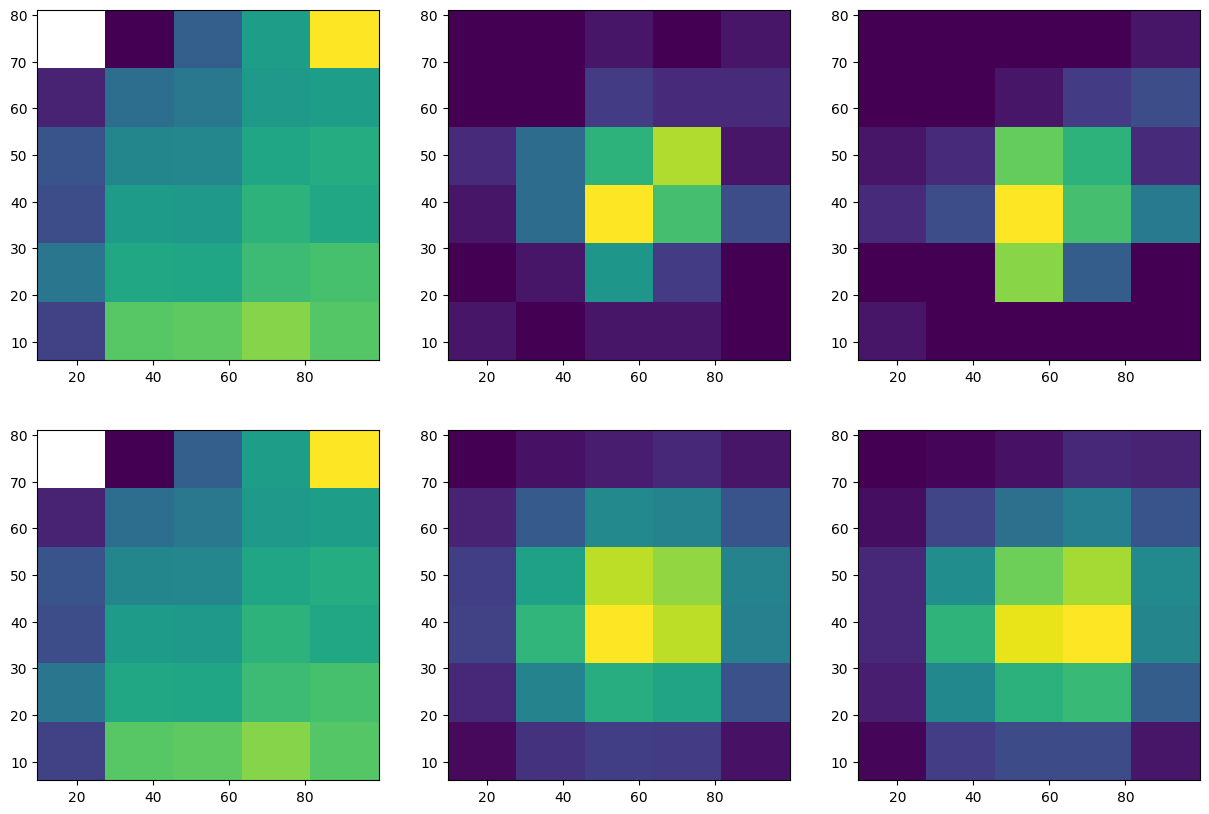

In [54]:

rmap, x_edges, y_edges, pos_binned, spikes_binned, pos_smoothed, spikes_smoothed = get_ratemaps(spikes, x, y, 3, binsize=15, stddev=5)
fig, ax = plt.subplots(2, 3, figsize=(3*5, 2*5))
ax = ax.flatten()
ax[0].imshow(rmap, 
           cmap='viridis', 
           interpolation = None,
           origin='lower', 
           aspect='auto', 
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])

ax[1].imshow(pos_binned, 
           interpolation='nearest', 
           cmap='viridis', 
           origin='lower', 
           aspect='auto', 
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])

ax[2].imshow(spikes_binned, 
           interpolation='nearest', 
           cmap='viridis', 
           origin='lower', 
           aspect='auto', 
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])

ax[3].imshow(rmap, 
           cmap='viridis', 
           interpolation = None,
           origin='lower', 
           aspect='auto', 
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])


ax[4].imshow(pos_smoothed, 
           interpolation='nearest', 
           cmap='viridis', 
           origin='lower', 
           aspect='auto', 
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])

ax[5].imshow(spikes_smoothed, 
           interpolation='nearest', 
           cmap='viridis', 
           origin='lower', 
           aspect='auto', 
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])



C:\Users\Sophia\AppData\Local\Temp\ipykernel_17176\225136957.py:40: RuntimeWarning: invalid value encountered in divide
  rmap = smoothed_spikes/smoothed_pos


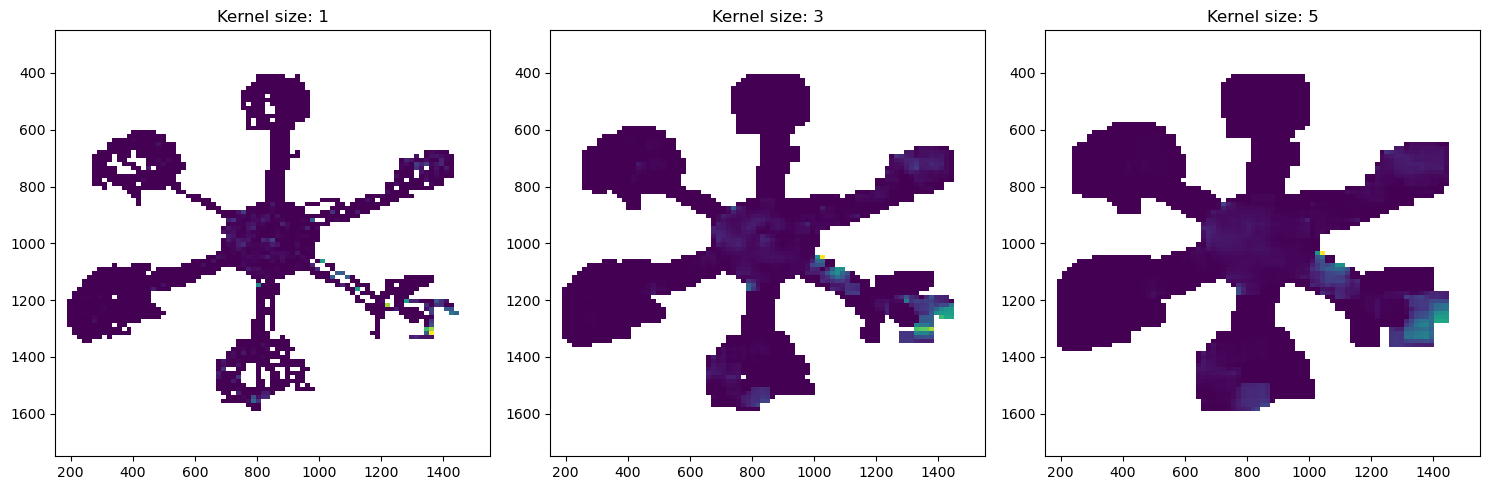

In [21]:
derivatives_base = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials" 
kilosort_output_path = os.path.join(derivatives_base,  "concat_run","sorting", "sorter_output" )
sorting = se.read_kilosort(
    folder_path = kilosort_output_path
)


unit_id = 229
frame_rate = 25
sample_rate = 30000


spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.int32(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
spike_train_org = np.copy(spike_train)



xy_hd_trial = pd.read_csv(r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\XY_HD_alltrials.csv")         
x = xy_hd_trial.iloc[:, 0].to_numpy()
y = xy_hd_trial.iloc[:, 1].to_numpy()

kernel = 1
counter = 0

fig, ax = plt.subplots(1,3, figsize=(15, 5), tight_layout=True)
ax = ax.flatten()


for i in range(3):
    rmap, x_edges, y_edges, pos_binned, spikes_binned, pos_smoothed, spikes_smoothed = get_ratemaps(spike_train, x, y, kernel, binsize=15, stddev=5)
    ax[counter].imshow(rmap, 
           cmap='viridis', 
           interpolation = None,
           origin='lower', 
           aspect='auto', 
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    ax[counter].set_xlim(150,1550)
    ax[counter].set_ylim(1750,250)
    ax[counter].set_title(f"Kernel size: {kernel}")
    counter += 1
    kernel += 2
plt.show()
